# Collaborative Filtering

Collaborative filtering considers users’ opinion on different products and recommends the best products based on the products’ previous rankings and the opinion of other similar types of users. 
* The good side is that this method does not rely on knowledge of the product.
* The down side is that it is not achievable for new products where it has no ratings yet. (Can solve by using ratings data from other platforms on the same product?)
* Also, it requires all user community to be active and may suffer from sparsity problem.

## Different types of collaborative filtering:

**Non-probabilistic algorithm**
* Memory-based
    * User-based 
    * Item-based 
* Model-based 

**Probabilistic algorithm**
* Bayesian-network model
* EM algorithm

## Issues in collaborative filtering:

* Sparseness in user-item matrix (sparsity=$1-|R|/|I|*|U|$)
* Cold start: 
    * How to recommend a new video to users?
    * What to recommend to new users?
* Cold start solutions:
    * Suggest or ask users to rate products
    * Default voting for products
    * Content-based or demographic

## Implementation (with `surprise`)

**cross validation**
- `cross_validate()`
    - `KFold()`
    - `RepeatedKFold()`
    - `ShuffleSplit()`
    - `LeaveOneOut()`
- `train_test_split()` and `test()`
- `build_full_trainset()` and `predict()`

<span style="color:red">What does build_full_trainset mean?? can i use train_test_split and then cross_validate on trainset and then predict testset?</span>

<span style="color:red">For implementation, should i also try out different cross validating methods?</span>

**Parameter search**
- `GridSearchCV()`

**Evaluation**



Source: [surprise documentation](https://surprise.readthedocs.io/en/stable/getting_started.html)

### import requirements

In [1]:
# import library
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset
from surprise import Reader
from surprise import SVDpp
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import accuracy

In [2]:
# load data
df = pd.read_csv('books/Ratings.csv')
df.head(3)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


### data preprocessing

In [3]:
df.columns = ['uid', 'bid', 'rating']

In [4]:
df.shape

(1149780, 3)

In [5]:
df.isnull().sum()

uid       0
bid       0
rating    0
dtype: int64

In [6]:
df['rating'].describe()

count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [7]:
df['rating'].value_counts()

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: rating, dtype: int64

In [8]:
df['rating'].value_counts()[0]/df.shape[0]

0.6228226269373272

More than half of our data do not have ratings, and we will have to drop them.

In [9]:
df.shape[0]-df['rating'].value_counts()[0]

433671

In [10]:
indices0 = df[df['rating']==0].index
df1 = df.drop(indices0)

In [11]:
df1.shape

(433671, 3)

After dropping the data without ratings, we still have `433671` entries, which is sufficient for us to build a recommender system.

**P.S.** It is important to note that for the purpose of collaborative filtering, I have to drop data without ratings, but for example, if we are building recommender systems using other methods such as content-based algorithm, we can keep these entries.

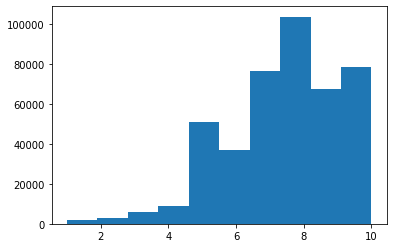

In [12]:
plt.hist(df1['rating'])
plt.show()

In [13]:
df1['rating'].describe()

count    433671.000000
mean          7.601066
std           1.843798
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: rating, dtype: float64

Books without ratings or having users that never rated a book is the common issue in ecommerce businesses about **"cold-start"**, which collabortative filtering suffer. That is why we need content-based as well as popularity methods as complimentary solutions for recommender systems. 

We might also need to drop users who have rated less than 10 books and books that have less than 50 ratings.

In [14]:
# getting the new dataframe which contains books which has received 50 or more ratings
df2 = df1.groupby("bid").filter(lambda x:x['rating'].count()>=30)
df2.shape #50000

(73006, 3)

In [15]:
# getting the new dataframe which contains users which has given 10 or more ratings
df3 = df2.groupby("uid").filter(lambda x:x['rating'].count()>=5)
df3.shape #14060

(38875, 3)

In [16]:
df3.shape[0]/df.shape[0] # 0.012

0.033810815982187895

After all the preprocessing, we only have `3%` left of our original data size, which is a managable size to deal with, but also means that this approach is not good enough and that we need other complementary approaches.

In [17]:
len(set(df3['uid'])) # 784

3215

In [18]:
len(set(df3['bid'])) # 537

1147

In [19]:
df3.to_csv('recommender_cf.csv')

In [20]:
#sns.countplot(x='bid', data=df)
#plt.title('Number of Ratings Books Received')
#plt.xlabel('Books')
#plt.ylabel('Ratings Counts')
#plt.savefig('')

In [21]:
#sns.countplot(x='uid', data=df)
#plt.title('Number of Ratings Given by Users')
#plt.xlabel('Users')
#plt.ylabel('Ratings Counts')
#plt.savefig('')

Data sets for Recommender Systems often have few items that contain the most ratings, whereas most of the items have very few ratings. This affects accuracy measurements as the accuracy predictions will generally be different on the popular items than the sparsely rated items. A solution to this problem is to give item specific weights toward each of the items when computing RSME or MAE, which are decided by the merchant. These could allow for a more accurate representation of how the Recommender System is evaluating all of the items

### data loading

In [22]:
reader = Reader(rating_scale=(1,10))

In [23]:
data = Dataset.load_from_df(df3[['uid', 'bid', 'rating']], reader)

## cross-validation
`cross_validate(algo, data, measures=[u'rmse', u'mae'], cv=None)`
- `cv`: Determines how the data parameter will be split. If an int is passed, `KFold` is used with the appropriate `n_splits` parameter. Default is used with `n_splits=5`.
- `verbose`: If `True` accuracy measures for each split are printed, as well as train and test times. Averages and standard deviations over all splits are also reported.

In [24]:
algo = SVDpp()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.5567  1.5874  1.5670  1.5704  0.0128  
MAE (testset)     1.1977  1.2057  1.1991  1.2008  0.0035  
Fit time          8.57    8.55    8.57    8.57    0.01    
Test time         0.48    0.41    0.39    0.43    0.04    


{'test_rmse': array([1.55670324, 1.587386  , 1.56697047]),
 'test_mae': array([1.19772939, 1.20566819, 1.19911776]),
 'fit_time': (8.574179887771606, 8.552494764328003, 8.574100255966187),
 'test_time': (0.47956418991088867, 0.4145498275756836, 0.39098525047302246)}

### more control over cross-validation
- `KFold(n_splits=5, random_state=None, shuffle=True)`

- `RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)`: repeats `KFold` n times with different randomization.

- `ShuffleSplit()`: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different.

- `LeaveOneOut((n_splits=5, random_state=None, min_n_ratings=0)`: cross-validation iterator where each user has exactly one rating in the testset.

In [25]:
algo = SVDpp()
kf = KFold(n_splits=3)
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions, verbose=True)

RMSE: 1.5631
RMSE: 1.5778
RMSE: 1.5681


### `train_test_split()`

In [26]:
trainset, testset = train_test_split(data, test_size=.25)
algo = SVDpp()
predictions = algo.fit(trainset).test(testset)

In [27]:
accuracy.rmse(predictions)

RMSE: 1.5511


1.5511283384941121

### `build_full_trainset()`

### item_based

In [28]:
trainset = data.build_full_trainset()

algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [29]:
test_pred = algo.test(testset)

In [30]:
accuracy.rmse(test_pred, verbose=True)

RMSE: 0.0802


0.08017413021465068

In [31]:
accuracy.mae(test_pred, verbose=True)

MAE:  0.0460


0.04595865514975558

### user_based

In [32]:
trainset = data.build_full_trainset()

algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [33]:
test_pred = algo.test(testset)

In [34]:
accuracy.rmse(test_pred, verbose=True)

RMSE: 0.0611


0.061108349053021774

In [35]:
accuracy.mae(test_pred, verbose=True)

MAE:  0.0364


0.03640693418710542

## Parameter Search
`GridSearchCV(algo_class, param_grid, measures=[u'rmse', u'mae'], cv=None, refit=False, return_train_measures=False)`

`RandomizedSearchCV`

Parameters
- `param_grid`

        param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [2, 3],
              'sim_options': {'name': ['msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [False]}
              }

Attributes
- `best_estimmator`
- `best_score`
- `best_params`
- `cv_results`
        results_df = pd.DataFrame.from_dict(gs.cv_results)
- ...

In [36]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

In [37]:
# best RMSE score
print(gs.best_score['rmse'])

1.5869606813188082


In [38]:
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [39]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,1.669092,1.675901,1.672627,1.672540,0.002780,7,1.299553,1.302288,1.306747,1.302862,0.002965,7,2.144402,0.065682,0.416659,0.056014,"{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}",5,0.002,0.4
1,1.670916,1.678003,1.674262,1.674394,0.002895,8,1.301055,1.303923,1.307969,1.304316,0.002836,8,2.152929,0.114597,0.392014,0.049973,"{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.6}",5,0.002,0.6
2,1.619604,1.624127,1.624651,1.622794,0.002266,3,1.262690,1.263602,1.269076,1.265123,0.002820,3,2.082210,0.074859,0.375560,0.041545,"{'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.4}",5,0.005,0.4
3,1.624315,1.628819,1.628663,1.627266,0.002087,4,1.266856,1.267571,1.273524,1.269317,0.002989,4,2.114072,0.085498,0.401173,0.037537,"{'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.6}",5,0.005,0.6
4,1.632807,1.637000,1.636942,1.635583,0.001963,5,1.273117,1.273336,1.278990,1.275147,0.002719,5,4.326846,0.104060,0.394228,0.047052,"{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.4}",10,0.002,0.4


## Evaluation

### MAE (mean absolute error)

Mean Average Error (MAE) does not give any bias to extrema in error terms. If there are outliers or large error terms, it will weigh those equally to the other predictions. Therefore, MAE should be preferred when looking toward rating accuracy when you’re not really looking toward the importance of outliers. To get a holistic view or representation of the Recommender System, use MAE.

### RMSE (root mean squared error)

Root Mean Squared Error tends to disproportionately penalize large errors as the residual (error term) is squared. This means RMSE is more prone to being affected by outliers or bad predictions.

MAE can only accurately recreate 0.8 of the data set. RSME is a lot more mathematically convenient whenever calculating distance, gradient, or other metrics. That’s why most cost functions in Machine Learning avoid using MAE and rather use sum of squared errors or Root Means Squared Error.

By definition, RMSE will never be as small as MAE. [This paper](https://gmd.copernicus.org/articles/7/1247/2014/gmd-7-1247-2014.pdf) establishes that both metrics are useful in evaluating algorithms.

## How to get top-N recommendations for each user
Source: [documentation](https://surprise.readthedocs.io/en/stable/FAQ.html)

We first train an SVD algorithm on the whole dataset, and then predict all the ratings for the pairs (user, item) that are not in the training set. We then retrieve the top-10 prediction for each user.